In [1]:
#!pip install pyforest

The 2012 US Army Anthropometric Survey (ANSUR II) was executed by the Natick Soldier Research, Development and Engineering Center (NSRDEC) from October 2010 to April 2012 and is comprised of personnel representing the total US Army force to include the US Army Active Duty, Reserves, and National Guard. In addition to the anthropometric and demographic data described below, the ANSUR II database also consists of 3D whole body, foot, and head scans of Soldier participants. These 3D data are not publicly available out of respect for the privacy of ANSUR II participants. The data from this survey are used for a wide range of equipment design, sizing, and tariffing applications within the military and has many potential commercial, industrial, and academic applications.

The ANSUR II working databases contain 93 anthropometric measurements which were directly measured, and 15 demographic/administrative variables explained below. The ANSUR II Male working database contains a total sample of 4,082 subjects. The ANSUR II Female working database contains a total sample of 1,986 subjects.


data dict:
https://data.world/datamil/ansur-ii-data-dictionary/workspace/file?filename=ANSUR+II+Databases+Overview.pdf


# Import libraries

In [2]:
import pandas as pd
import pyforest
import plotly
import cufflinks as cf
#Enabling the offline mode for interactive plotting locally
from plotly.offline import download_plotlyjs,init_notebook_mode,plot,iplot
init_notebook_mode(connected=True)
cf.go_offline()
#To display the plots
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.metrics import make_scorer
from sklearn.metrics import classification_report,confusion_matrix,plot_confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [3]:
def plot_multiclass_roc(clf, X_test, y_test, n_classes, figsize=(5,5)):
    y_score = clf.decision_function(X_test)

    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # calculate dummies once
    y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic example')
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for label %i' % (roc_auc[i], i))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()

In [4]:
def plot_multiclass_roc_for_tree(clf, X_test, y_test, n_classes, figsize=(5,5)):
    y_score = clf.predict_proba(X_test)

    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # calculate dummies once
    y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic example')
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for label %i' % (roc_auc[i], i))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()

# Ingest Data from links below and make a dataframe
- Soldiers Male : https://query.data.world/s/h3pbhckz5ck4rc7qmt2wlknlnn7esr
- Soldiers Female : https://query.data.world/s/sq27zz4hawg32yfxksqwijxmpwmynq

In [5]:
df_male = pd.read_csv('https://query.data.world/s/h3pbhckz5ck4rc7qmt2wlknlnn7esr',encoding='latin-1')

In [6]:
df_female= pd.read_csv('https://query.data.world/s/sq27zz4hawg32yfxksqwijxmpwmynq')

# EDA
- Drop unnecessary colums
- Drop DODRace class if value count below 500 (we assume that our data model can't learn if it is below 500)

In [7]:
df_male.head()

,subjectid,abdominalextensiondepthsitting,acromialheight,acromionradialelength,anklecircumference,axillaheight,balloffootcircumference,balloffootlength,biacromialbreadth,bicepscircumferenceflexed,...,Branch,PrimaryMOS,SubjectsBirthLocation,SubjectNumericRace,Ethnicity,DODRace,Age,Heightin,Weightlbs,WritingPreference
0,10027,266,1467,337,222,1347,253,202,401,369,...,Combat Arms,19D,North Dakota,1,NaN,1,41,71,180,Right hand
1,10032,233,1395,326,220,1293,245,193,394,338,...,Combat Support,68W,New York,1,NaN,1,35,68,160,Left hand
2,10033,287,1430,341,230,1327,256,196,427,408,...,Combat Support,68W,New York,2,NaN,2,42,68,205,Left hand
3,10092,234,1347,310,230,1239,262,199,401,359,...,Combat Service Support,88M,Wisconsin,1,NaN,1,31,66,175,Right hand
4,10093,250,1585,372,247,1478,267,224,435,356,...,Combat Service Support,92G,North Carolina,2,NaN,2,21,77,213,Right hand


In [8]:
df_female.head()

,SubjectId,abdominalextensiondepthsitting,acromialheight,acromionradialelength,anklecircumference,axillaheight,balloffootcircumference,balloffootlength,biacromialbreadth,bicepscircumferenceflexed,...,Branch,PrimaryMOS,SubjectsBirthLocation,SubjectNumericRace,Ethnicity,DODRace,Age,Heightin,Weightlbs,WritingPreference
0,10037,231,1282,301,204,1180,222,177,373,315,...,Combat Support,92Y,Germany,2,NaN,2,26,61,142,Right hand
1,10038,194,1379,320,207,1292,225,178,372,272,...,Combat Service Support,25U,California,3,Mexican,3,21,64,120,Right hand
2,10042,183,1369,329,233,1271,237,196,397,300,...,Combat Service Support,35D,Texas,1,NaN,1,23,68,147,Right hand
3,10043,261,1356,306,214,1250,240,188,384,364,...,Combat Service Support,25U,District of Columbia,8,Caribbean Islander,2,22,66,175,Right hand
4,10051,309,1303,308,214,1210,217,182,378,320,...,Combat Arms,42A,Texas,1,NaN,1,45,63,195,Right hand


In [9]:
print(df_male.shape)
print(df_female.shape)

(4082, 108)
(1986, 108)


In [10]:
data = pd.concat([df_male,df_female], axis=0,ignore_index=True)

In [11]:
data.shape

(6068, 109)

In [12]:
with pd.option_context('display.max_columns', None):
    display(data.head())

,subjectid,abdominalextensiondepthsitting,acromialheight,acromionradialelength,anklecircumference,axillaheight,balloffootcircumference,balloffootlength,biacromialbreadth,bicepscircumferenceflexed,bicristalbreadth,bideltoidbreadth,bimalleolarbreadth,bitragionchinarc,bitragionsubmandibulararc,bizygomaticbreadth,buttockcircumference,buttockdepth,buttockheight,buttockkneelength,buttockpopliteallength,calfcircumference,cervicaleheight,chestbreadth,chestcircumference,chestdepth,chestheight,crotchheight,crotchlengthomphalion,crotchlengthposterioromphalion,earbreadth,earlength,earprotrusion,elbowrestheight,eyeheightsitting,footbreadthhorizontal,footlength,forearmcenterofgriplength,forearmcircumferenceflexed,forearmforearmbreadth,forearmhandlength,functionalleglength,handbreadth,handcircumference,handlength,headbreadth,headcircumference,headlength,heelanklecircumference,heelbreadth,hipbreadth,hipbreadthsitting,iliocristaleheight,interpupillarybreadth,interscyei,interscyeii,kneeheightmidpatella,kneeheightsitting,lateralfemoralepicondyleheight,lateralmalleolusheight,lowerthighcircumference,mentonsellionlength,neckcircumference,neckcircumferencebase,overheadfingertipreachsitting,palmlength,poplitealheight,radialestylionlength,shouldercircumference,shoulderelbowlength,shoulderlength,sittingheight,sleevelengthspinewrist,sleeveoutseam,span,stature,suprasternaleheight,tenthribheight,thighcircumference,thighclearance,thumbtipreach,tibialheight,tragiontopofhead,trochanterionheight,verticaltrunkcircumferenceusa,waistbacklength,waistbreadth,waistcircumference,waistdepth,waistfrontlengthsitting,waistheightomphalion,weightkg,wristcircumference,wristheight,Gender,Date,Installation,Component,Branch,PrimaryMOS,SubjectsBirthLocation,SubjectNumericRace,Ethnicity,DODRace,Age,Heightin,Weightlbs,WritingPreference,SubjectId
0,10027.0,266,1467,337,222,1347,253,202,401,369,274,493,71,319,291,142,979,240,882,619,509,373,1535,291,1074,259,1292,877,607,351,36,71,19,247,802,101,273,349,299,575,477,1136,90,214,193,150,583,206,326,70,332,366,1071,685,422,441,502,560,500,77,391,118,400,436,1447,113,437,273,1151,368,145,928,883,600,1782,1776,1449,1092,610,164,786,491,140,919,1700,501,329,933,240,440,1054,815,175,853,Male,4-Oct-10,Fort Hood,Regular Army,Combat Arms,19D,North Dakota,1,NaN,1,41,71,180,Right hand,NaN
1,10032.0,233,1395,326,220,1293,245,193,394,338,257,479,67,344,320,135,944,232,870,584,468,357,1471,269,1021,253,1244,851,615,376,33,62,18,232,781,98,263,348,289,523,476,1096,86,203,195,146,568,201,334,72,312,356,1046,620,441,447,490,540,488,73,371,131,380,420,1380,118,417,254,1119,353,141,884,868,564,1745,1702,1387,1076,572,169,822,476,120,918,1627,432,316,870,225,371,1054,726,167,815,Male,4-Oct-10,Fort Hood,Regular Army,Combat Support,68W,New York,1,NaN,1,35,68,160,Left hand,NaN
2,10033.0,287,1430,341,230,1327,256,196,427,408,261,544,75,345,330,135,1054,258,901,623,506,412,1501,288,1120,267,1288,854,636,359,40,61,23,237,810,103,270,355,357,575,491,1115,93,220,203,148,573,202,356,70,349,393,1053,665,462,475,496,556,482,72,409,123,403,434,1447,121,431,268,1276,367,167,917,910,604,1867,1735,1438,1105,685,198,807,477,125,918,1678,472,329,964,255,411,1041,929,180,831,Male,4-Oct-10,Fort Hood,Regular Army,Combat Support,68W,New York,2,NaN,2,42,68,205,Left hand,NaN
3,10092.0,234,1347,310,230,1239,262,199,401,359,262,518,73,328,309,143,991,242,821,560,437,395,1423,296,1114,262,1205,769,590,341,39,66,25,272,794,106,267,352,318,593,467,1034,91,217,194,158,576,199,341,68,338,367,986,640,458,461,460,511,452,76,393,106,407,446,1357,118,393,249,1155,330,148,903,848,550,1708,1655,1346,1021,604,180,803,445,127,847,1625,461,315,857,205,399,968,794,176,793,Male,12-Oct-10,Fort Hood,Regular Army,Combat Service Support,88M,Wisconsin,1,NaN,1,31,66,175,Right hand,NaN
4,10093.0,250,1585,372,247,1478,267,224,435,356,263,524,80,340,310,138,1029,275,1080,706,567,425,1684,304,1048,232,1452,1014,682,382,32,56,19,188,814,111,305,399,324,605,550,1279,94,222,218,153,566,197,374,69,332,372

In [13]:
data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6068 entries, 0 to 6067
Data columns (total 109 columns):
 #    Column                          Dtype  
---   ------                          -----  
 0    subjectid                       float64
 1    abdominalextensiondepthsitting  int64  
 2    acromialheight                  int64  
 3    acromionradialelength           int64  
 4    anklecircumference              int64  
 5    axillaheight                    int64  
 6    balloffootcircumference         int64  
 7    balloffootlength                int64  
 8    biacromialbreadth               int64  
 9    bicepscircumferenceflexed       int64  
 10   bicristalbreadth                int64  
 11   bideltoidbreadth                int64  
 12   bimalleolarbreadth              int64  
 13   bitragionchinarc                int64  
 14   bitragionsubmandibulararc       int64  
 15   bizygomaticbreadth              int64  
 16   buttockcircumference            int64  
 17   buttockdepth

In [14]:
data.isnull().sum().any()

True

In [15]:
data.duplicated().sum()

0

1    3792
2    1298
3     679
4     188
6      59
5      49
8       3
Name: DODRace, dtype: int64


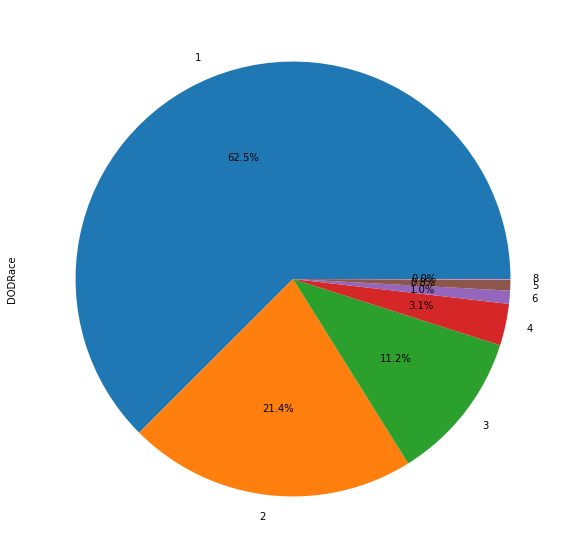

In [16]:
print(data["DODRace"].value_counts())
data["DODRace"].value_counts().plot(kind="pie", autopct='%1.1f%%',figsize=(10,10));

In [17]:
drop_list =[]
for col in data.columns:
    if data[col].isnull().sum()>1800:
        print(f"{col} = {data[col].isnull().sum()}")
        drop_list.append(col)
  
  
drop_list 

subjectid = 1986
Ethnicity = 4647
SubjectId = 4082


['subjectid', 'Ethnicity', 'SubjectId']

In [18]:
data.drop(drop_list,axis=1, inplace=True)

In [19]:
data.isnull().sum().any()

False

In [20]:
data.shape

(6068, 106)

In [21]:
# to find how many unique values object features have
for col in data.select_dtypes(exclude=[np.number]).columns:
  print(f"{col} has {data[col].nunique()} unique value")
    

<IPython.core.display.Javascript object>

Gender has 2 unique value
Date has 253 unique value
Installation has 12 unique value
Component has 3 unique value
Branch has 3 unique value
PrimaryMOS has 285 unique value
SubjectsBirthLocation has 152 unique value
WritingPreference has 3 unique value


In [22]:
data["DODRace"] = data.DODRace.map({
    1: "White",
    2: "Black",
    3: "Hispanic",
    4: "Asian",
    5: "Native American",
    6: "Pacific Islander",
    8: "Other"
})

In [60]:
data.DODRace.value_counts()

White       3792
Black       1298
Hispanic     679
Name: DODRace, dtype: int64

In [23]:
data.groupby(["Component"])["DODRace"].value_counts().iplot(kind="barh")

In [24]:
data.groupby(["Component",
              "Branch"])["DODRace"].value_counts().iplot(kind="barh")

In [25]:
drop_list1 = [
    "Date", "Installation", "Component", "Branch", "PrimaryMOS",
    "Weightlbs", "Heightin",   
]

data.drop(drop_list1, axis=1, inplace=True)

In [26]:
data.columns

Index(['abdominalextensiondepthsitting', 'acromialheight',
       'acromionradialelength', 'anklecircumference', 'axillaheight',
       'balloffootcircumference', 'balloffootlength', 'biacromialbreadth',
       'bicepscircumferenceflexed', 'bicristalbreadth', 'bideltoidbreadth',
       'bimalleolarbreadth', 'bitragionchinarc', 'bitragionsubmandibulararc',
       'bizygomaticbreadth', 'buttockcircumference', 'buttockdepth',
       'buttockheight', 'buttockkneelength', 'buttockpopliteallength',
       'calfcircumference', 'cervicaleheight', 'chestbreadth',
       'chestcircumference', 'chestdepth', 'chestheight', 'crotchheight',
       'crotchlengthomphalion', 'crotchlengthposterioromphalion', 'earbreadth',
       'earlength', 'earprotrusion', 'elbowrestheight', 'eyeheightsitting',
       'footbreadthhorizontal', 'footlength', 'forearmcenterofgriplength',
       'forearmcircumferenceflexed', 'forearmforearmbreadth',
       'forearmhandlength', 'functionalleglength', 'handbreadth',
      

In [27]:
data.SubjectNumericRace.value_counts()

1        3561
2        1026
3         541
31        160
51        126
8         116
4         109
21         60
6          59
41         46
61         35
23         34
28         26
251        20
18         18
5          18
25         14
351        10
38          9
35          8
62          8
64          8
63          7
42          7
231         6
43          5
235         4
218         3
651         2
423         2
451         2
431         2
318         2
2351        2
641         2
2518        2
631         1
238         1
358         1
425         1
4251        1
428         1
48          1
42351       1
Name: SubjectNumericRace, dtype: int64

In [28]:
data.drop("SubjectNumericRace",axis=1,inplace=True)

In [29]:
data.DODRace.value_counts()

White               3792
Black               1298
Hispanic             679
Asian                188
Pacific Islander      59
Native American       49
Other                  3
Name: DODRace, dtype: int64

In [30]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6068 entries, 0 to 6067
Data columns (total 98 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   abdominalextensiondepthsitting  6068 non-null   int64 
 1   acromialheight                  6068 non-null   int64 
 2   acromionradialelength           6068 non-null   int64 
 3   anklecircumference              6068 non-null   int64 
 4   axillaheight                    6068 non-null   int64 
 5   balloffootcircumference         6068 non-null   int64 
 6   balloffootlength                6068 non-null   int64 
 7   biacromialbreadth               6068 non-null   int64 
 8   bicepscircumferenceflexed       6068 non-null   int64 
 9   bicristalbreadth                6068 non-null   int64 
 10  bideltoidbreadth                6068 non-null   int64 
 11  bimalleolarbreadth              6068 non-null   int64 
 12  bitragionchinarc                6068 non-null   

In [31]:
data["DODRace"].unique()

array(['White', 'Black', 'Hispanic', 'Asian', 'Native American',
       'Pacific Islander', 'Other'], dtype=object)

In [32]:
data = data.loc[(data["DODRace"] == "White") | (data["DODRace"] == "Black") |
                (data["DODRace"] == "Hispanic")]

In [33]:
data.reset_index(drop=True, inplace=True)

In [34]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
abdominalextensiondepthsitting,5769.0,247.254290,37.457748,155.0,220.0,243.0,272.0,451.0
acromialheight,5769.0,1408.630265,78.303123,1146.0,1353.0,1412.0,1464.0,1683.0
acromionradialelength,5769.0,328.071590,20.444554,249.0,314.0,328.0,342.0,393.0
anklecircumference,5769.0,225.201768,15.965783,156.0,214.0,225.0,235.0,293.0
axillaheight,5769.0,1301.902583,71.260913,1062.0,1252.0,1304.0,1351.0,1553.0
...,...,...,...,...,...,...,...,...
waistheightomphalion,5769.0,1033.591090,61.957938,808.0,990.0,1035.0,1077.0,1245.0
weightkg,5769.0,800.981106,155.990338,358.0,686.0,790.0,900.0,1442.0
wristcircumference,5769.0,169.308372,13.060900,124.0,159.0,171.0,179.0,216.0
wristheight,5769.0,831.334547,47.321580,688.0,798.0,831.0,864.0,1009.0


In [35]:
data.reset_index(drop=True, inplace=True)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<AxesSubplot:>

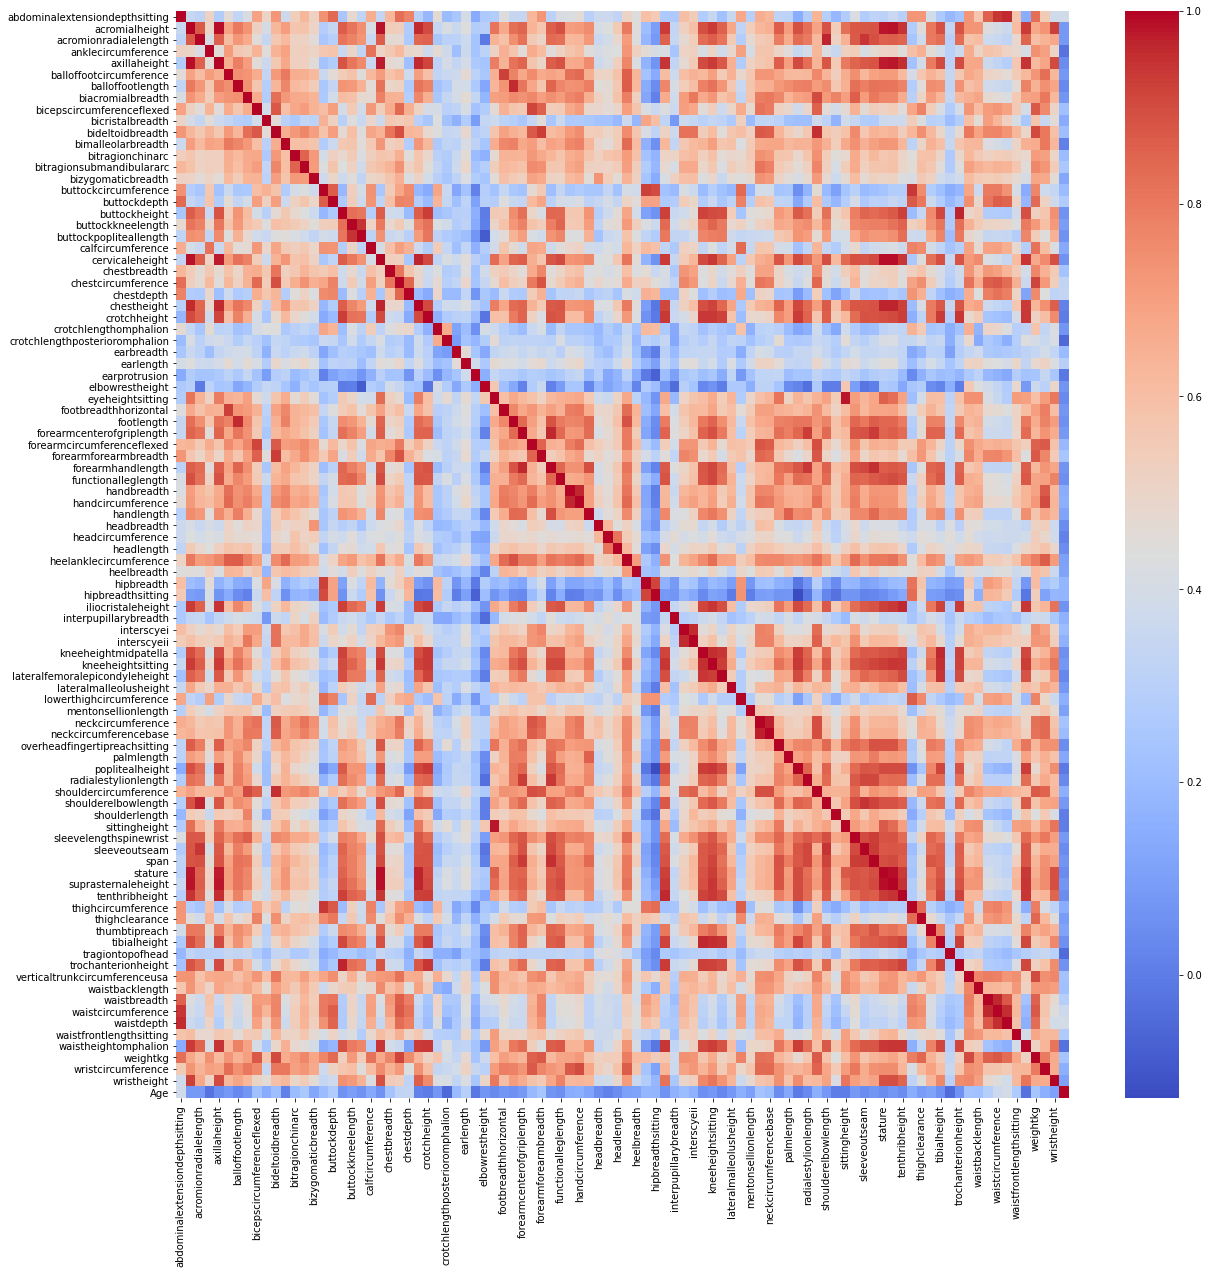

In [36]:
plt.figure(figsize=(20,20))
sns.heatmap(data.corr(), cmap ="coolwarm")

In [37]:
df_temp = data.corr()

count = "done"
feature =[]
collinear=[]
for col in df_temp.columns:
    for i in df_temp.index:
        if (df_temp[col][i]> .9 and df_temp[col][i] < 1) or (df_temp[col][i]< -.9 and df_temp[col][i] > -1) :
                feature.append(col)
                collinear.append(i)
                # print(f"multicolinearity alert in between {col} - {i}")
print("Number of strong corelated features:", count) 

Number of strong corelated features: done


In [38]:
df_col = pd.DataFrame([feature, collinear], index=["feature","collinear"]).T
df_col

,feature,collinear
0,abdominalextensiondepthsitting,waistcircumference
1,abdominalextensiondepthsitting,waistdepth
2,acromialheight,axillaheight
3,acromialheight,cervicaleheight
4,acromialheight,chestheight
...,...,...
281,weightkg,chestcircumference
282,weightkg,verticaltrunkcircumferenceusa
283,wristcircumference,handcircumference
284,wristheight,acromialheight


In [39]:
df_col.value_counts("feature")

feature
kneeheightsitting                 19
iliocristaleheight                15
tenthribheight                    15
axillaheight                      14
waistheightomphalion              14
crotchheight                      14
cervicaleheight                   14
kneeheightmidpatella              12
suprasternaleheight               12
chestheight                       11
tibialheight                      11
acromialheight                    10
poplitealheight                   10
span                               9
trochanterionheight                9
stature                            9
lateralfemoralepicondyleheight     7
buttockheight                      7
sleeveoutseam                      6
forearmhandlength                  5
radialestylionlength               4
shoulderelbowlength                3
functionalleglength                3
waistcircumference                 3
bideltoidbreadth                   3
weightkg                           3
forearmcenterofgriplength     

# DATA Preprocessing
- In this step we divide our data to X(Features) and y(Target) then ,
- To train and evaluation purposes we create train and test sets,
- Lastly, scale our data if features not in same scale. Why?

In [40]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5769 entries, 0 to 5768
Data columns (total 98 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   abdominalextensiondepthsitting  5769 non-null   int64 
 1   acromialheight                  5769 non-null   int64 
 2   acromionradialelength           5769 non-null   int64 
 3   anklecircumference              5769 non-null   int64 
 4   axillaheight                    5769 non-null   int64 
 5   balloffootcircumference         5769 non-null   int64 
 6   balloffootlength                5769 non-null   int64 
 7   biacromialbreadth               5769 non-null   int64 
 8   bicepscircumferenceflexed       5769 non-null   int64 
 9   bicristalbreadth                5769 non-null   int64 
 10  bideltoidbreadth                5769 non-null   int64 
 11  bimalleolarbreadth              5769 non-null   int64 
 12  bitragionchinarc                5769 non-null   

In [41]:
X= data.drop("DODRace",axis=1)
X = pd.get_dummies(data=X,drop_first=True)
y= data.DODRace

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23, stratify =y)

<IPython.core.display.Javascript object>

In [43]:
scaler =MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Modelling
- Fit the model with train dataset
- Get predict from vanilla model on both train and test sets to examine if there is over/underfitting   
- Apply GridseachCV for both hyperparemeter tuning and sanity test of our model.
- Use hyperparameters that you find from gridsearch and make final prediction and evaluate the result according to chosen metric.

## 1. Logistic model

### Vanilla Logistic Model

test scores 
--------------
[[234  12  14]
 [  6 113  17]
 [ 23 115 620]]
              precision    recall  f1-score   support

       Black       0.89      0.90      0.89       260
    Hispanic       0.47      0.83      0.60       136
       White       0.95      0.82      0.88       758

    accuracy                           0.84      1154
   macro avg       0.77      0.85      0.79      1154
weighted avg       0.88      0.84      0.85      1154



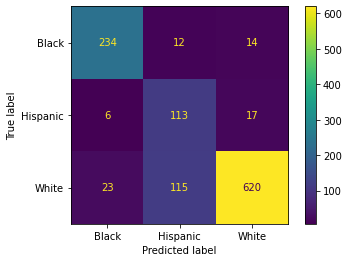

In [44]:
log_model = LogisticRegression(class_weight='balanced',max_iter=10000,random_state=6)

log_model.fit(X_train,y_train)

y_pred = log_model.predict(X_test)

print("test scores","\n--------------")

print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test, y_pred))
plot_confusion_matrix(log_model,X_test,y_test,values_format='.0f')

train scores 
--------------
[[ 978   39   21]
 [  21  453   69]
 [  59  363 2612]]
              precision    recall  f1-score   support

       Black       0.92      0.94      0.93      1038
    Hispanic       0.53      0.83      0.65       543
       White       0.97      0.86      0.91      3034

    accuracy                           0.88      4615
   macro avg       0.81      0.88      0.83      4615
weighted avg       0.91      0.88      0.88      4615



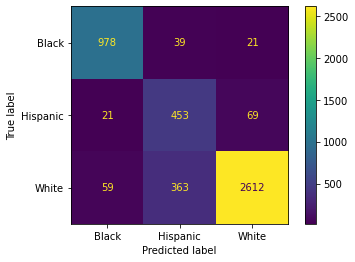

In [45]:
y_pred = log_model.predict(X_train)

print("train scores","\n--------------")

print(confusion_matrix(y_train,y_pred))

print(classification_report(y_train, y_pred))

plot_confusion_matrix(log_model,X_train,y_train);#x




### Logistic Model GridsearchCV

In [70]:
f1score= make_scorer(recall_score, average="weighted")

In [71]:
model = LogisticRegression(class_weight='balanced',
                           max_iter=10000,
                           random_state=6)
scores = cross_val_score(model,X_train,y_train,cv=5,scoring=f1score,n_jobs=-1)
print([round(i, 4) for i in scores], "\n")
print(f" f1score : %{scores.mean()*100:.2f}, std : %{scores.std()*100:.3f} \n")

[0.8635, 0.8321, 0.8483, 0.8548, 0.8646] 

 f1score : %85.27, std : %1.189 



In [72]:
f1_Hispanic =  make_scorer(f1_score, average=None, labels=["Hispanic"] )

In [73]:
param_grid = {
    "class_weight": ["balanced", None],
    'penalty': ["l1", "l2"],
    'solver': ['saga', 'lbfgs'],
}

In [76]:
model = LogisticRegression(class_weight='balanced',
                           max_iter=10000,
                           random_state=6)

log_model_grid = GridSearchCV(model,
                              param_grid,
                              verbose=3,
                              scoring=f1_Hispanic,
                              refit=True,
                              n_jobs=-1)

In [77]:
log_model_grid.fit(X_train,y_train)


Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(estimator=LogisticRegression(class_weight='balanced',
                                          max_iter=10000, random_state=6),
             n_jobs=-1,
             param_grid={'class_weight': ['balanced', None],
                         'penalty': ['l1', 'l2'], 'solver': ['saga', 'lbfgs']},
             scoring=make_scorer(f1_score, average=None, labels=['Hispanic']),
             verbose=3)

In [ ]:
log_model_grid.best_params_

In [ ]:
y_pred = log_model_grid.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
plot_confusion_matrix(log_model_grid, X_test, y_test)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

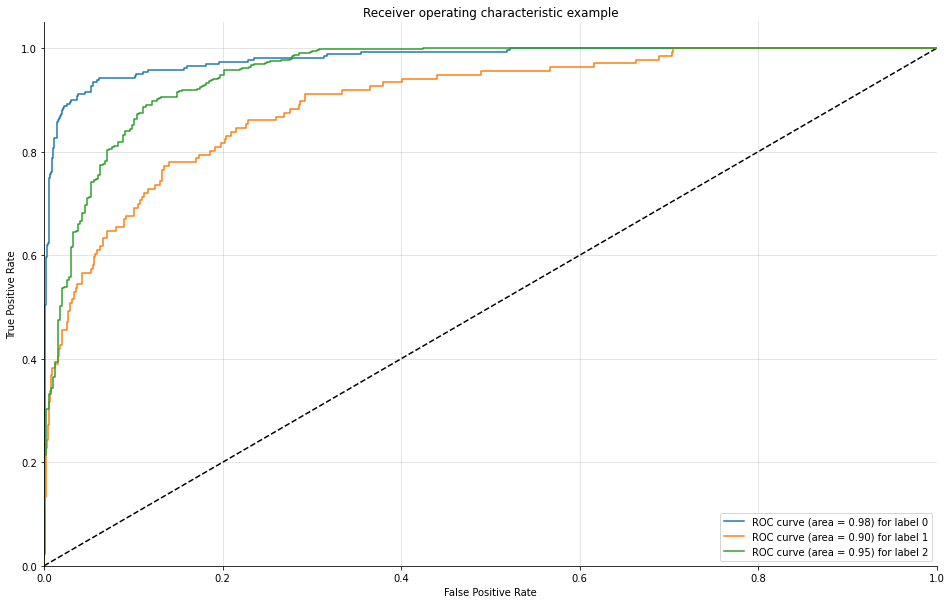

In [54]:
plot_multiclass_roc(log_model_grid,
                    X_test,
                    y_test,
                    n_classes=3,
                    figsize=(16, 10))

## 2. SVC

### Vanilla SVC model 

test scores 
--------------
[[234   8  18]
 [  8 108  20]
 [ 19 123 616]]
              precision    recall  f1-score   support

       Black       0.90      0.90      0.90       260
    Hispanic       0.45      0.79      0.58       136
       White       0.94      0.81      0.87       758

    accuracy                           0.83      1154
   macro avg       0.76      0.84      0.78      1154
weighted avg       0.87      0.83      0.84      1154



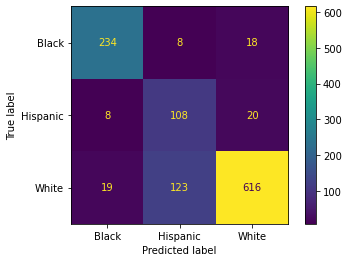

In [55]:
svm_model = SVC(class_weight="balanced")

svm_model.fit(X_train, y_train)

y_pred = svm_model.predict(X_test)

print("test scores","\n--------------")

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
plot_confusion_matrix(svm_model,X_test,y_test);#x

train scores 
--------------
[[ 955   40   43]
 [  21  449   73]
 [  56  409 2569]]
              precision    recall  f1-score   support

       Black       0.93      0.92      0.92      1038
    Hispanic       0.50      0.83      0.62       543
       White       0.96      0.85      0.90      3034

    accuracy                           0.86      4615
   macro avg       0.79      0.86      0.81      4615
weighted avg       0.90      0.86      0.87      4615



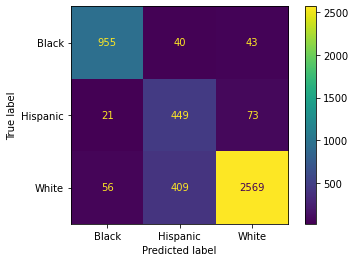

In [56]:
y_pred = svm_model.predict(X_train)

print("train scores","\n--------------")

print(confusion_matrix(y_train,y_pred))
print(classification_report(y_train, y_pred))
plot_confusion_matrix(svm_model,X_train,y_train);





###  SVC Model GridsearchCV

In [57]:
param_grid = {
    'C': np.linspace(200, 400, 5),
    'decision_function_shape': ['ovr', 'ovo'],
    'gamma': ["scale", "auto", 1, 0.1, 0.01],
    'kernel': ['rbf'],
    'class_weight': ["balanced", None]
}

<IPython.core.display.Javascript object>

In [58]:
model = SVC(class_weight="balanced")
svm_model_grid = GridSearchCV(model,
                              param_grid,
                              verbose=3,
                              scoring=f1_Hispanic,
                              refit=True,
                              n_jobs=-1)

In [59]:
svm_model_grid.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


KeyboardInterrupt: 

In [ ]:
svm_model_grid.best_params_

In [ ]:
y_pred = svm_model_grid.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
plot_confusion_matrix(svm_model_grid,X_test,y_test);

In [ ]:
plot_multiclass_roc(svm_model_grid,
                    X_test,
                    y_test,
                    n_classes=3,
                    figsize=(16, 10))

## 3. RF

### Vanilla RF Model

In [ ]:
rf_mod = RandomForestClassifier()

In [ ]:
rf_mod.fit(X_train,y_train)

In [ ]:
y_pred = rf_mod.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
plot_confusion_matrix(rf_mod, X_test, y_test);

In [ ]:
y_pred = rf_mod.predict(X_train)
print(confusion_matrix(y_train, y_pred))
print(classification_report(y_train, y_pred))
plot_confusion_matrix(rf_mod, X_train, y_train);

### RF Model GridsearchCV

In [ ]:
param_grid = {'n_estimators':[400,500],
             'criterion': ["gini","entropy"],
             'max_depth':[10,12,14,16],
             'min_samples_split':[18,20,22],
             'class_weight': ['balanced',None]}

In [ ]:
rf_model = RandomForestClassifier()
rf_grid_model = GridSearchCV(rf_model,
                             param_grid,
                             verbose=3,
                             scoring=f1_Hispanic,
                             refit=True,
                             n_jobs=-1)

In [ ]:
rf_grid_model.fit(X_train,y_train)

In [ ]:
rf_grid_model.best_params_

In [ ]:
y_pred = rf_grid_model.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
plot_confusion_matrix(rf_grid_model, X_test, y_test)

In [ ]:
plot_multiclass_roc_for_tree(rf_grid_model, 
                             X_test,
                             y_test, 
                             n_classes=3, 
                             figsize=(16, 10))

## 4. XGBoost

### Vanilla XGBoost Model

In [ ]:
xgb_model = XGBClassifier()

In [ ]:
from sklearn.utils import class_weight
classes_weights = class_weight.compute_sample_weight(class_weight='balanced', y=y_train)
classes_weights

In [ ]:
xgb_model.fit(X_train,y_train,sample_weight=classes_weights)
# weight parameter in XGBoost is per instance not per class. Therefore, we need to assign the weight of each class to its instances, which is the same thing.

In [ ]:
y_pred = xgb_model.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
plot_confusion_matrix(xgb_model,X_test,y_test);

In [ ]:
y_pred = xgb_model.predict(X_train)
print(confusion_matrix(y_train, y_pred))
print(classification_report(y_train, y_pred))
plot_confusion_matrix(xgb_model,X_train,y_train);

### XGBoost Model GridsearchCV

In [ ]:
comp = pd.DataFrame(classes_weights)

comp["label"]= y_train.reset_index(drop=True)
comp.groupby("label")[0].value_counts()

In [ ]:
param_grid = {"n_estimators":[100, 300],
              'max_depth':[3,5,6],
              "learning_rate": [0.1, 0.3],
              "subsample":[0.5, 1],
              "colsample_bytree":[0.5, 1]}

In [ ]:
xgb_model = XGBClassifier()
xgb_grid_model = GridSearchCV(xgb_model, param_grid, scoring=f1_Hispanic, n_jobs = -1,refit=True, verbose = 2).fit(X_train, y_train,sample_weight=classes_weights)

In [ ]:
xgb_grid_model.best_params_

In [ ]:
y_pred = xgb_grid_model.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
plot_confusion_matrix(xgb_grid_model,X_test,y_test);

In [ ]:
plot_multiclass_roc_for_tree(xgb_grid_model, X_test, y_test, n_classes=3, figsize=(16, 10))

---
---

# Before the Deployment 
- Choose the model that works best based on your chosen metric
- For final step, fit the best model with whole dataset to get better performance.
- And your model ready to deploy, dump your model and scaler.

In [ ]:
X_scaled = scaler.fit_transform(X)

In [ ]:
final_model = SVC(C=400,class_weight=None,decision_function_shape="ovr", gamma="auto",kernel="rbf" )
final_model.fit(X_scaled,y)

In [ ]:
X.describe().loc["mean"]

In [ ]:
a = pd.DataFrame(X.iloc[201])#x
a

In [ ]:
a = scaler.transform(a)

In [ ]:
final_model.predict(X_scaled[201].reshape(1,-1))

In [ ]:
y[201]

---
---

# SMOTE
https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/

##  Smote implement

In [ ]:
#!pip install imblearn

In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

In [ ]:
over = SMOTE(sampling_strategy={"Hispanic": 1200}, k_neighbors= 3)
under = RandomUnderSampler(sampling_strategy={"White": 2500}, replacement=True)

# we are configuring our pipeline steps
steps = [('o', over), ('u', under)]

# create a pipeline that will automatically apply over and under
# sampling in order to steps that we created.
pipeline = Pipeline(steps=steps)

# we will create new data over X_train and y_train.
# We simply delete some of our samples if its race "white" and we add synthetic samples to "hispanics".
X_resampled, y_resampled = pipeline.fit_resample(X_train, y_train)

In [ ]:
# from imblearn.combine import SMOTEENN,SMOTETomek
# ros1 = SMOTETomek()
# ros2 = SMOTEENN()
# X_resampled, y_resampled = ros1.fit_resample(X_train, y_train)
# X_resampled, y_resampled = ros2.fit_resample(X_train, y_train)

In [ ]:
# X_resampled, y_resampled = ros2.fit_resample(X_resampled, y_resampled)

In [ ]:
y_resampled.value_counts()

In [ ]:
y_train.value_counts()

## SVC Over/Under Sampling

In [ ]:
classes_weights = class_weight.compute_class_weight(class_weight='balanced',classes=np.unique(y_train), y=y_train)
classes_weights

In [ ]:
f1_Hispanic =  make_scorer(f1_score, average=None, labels = ["Hispanic"])
recall_Hispanic =  make_scorer(recall_score, average=None, labels = ["Hispanic"])
precision_Hispanic =  make_scorer(precision_score, average=None, labels = ["Hispanic"])
f1_score_weighed = make_scorer(f1_score, average="weighted")

In [ ]:
param_grid = {'C': np.linspace(200, 400, 5),
              'decision_function_shape' : ['ovr'], #ovo
              'gamma': ["scale", "auto", 1,2],
              'kernel': ['rbf'],
              'class_weight':["balanced",None]}

In [ ]:
model = SVC()
svm_model_grid = GridSearchCV(model,
                              param_grid,
                              cv=5,
                              scoring=f1_Hispanic,
                              refit=True,
                              n_jobs=-1)

In [ ]:
svm_model_grid.fit(X_resampled, y_resampled)

In [ ]:
svm_model_grid.best_params_

In [ ]:
y_pred = svm_model_grid.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
plot_confusion_matrix(svm_model_grid,X_test,y_test);

In [ ]:
plot_multiclass_roc(svm_model_grid,
                    X_test,
                    y_test,
                    n_classes=3,
                    figsize=(16, 10))

## Xgboost Over/ Under Sampling

In [ ]:
param_grid = {"n_estimators":[100, 300],
              'max_depth':[6,8],
              "learning_rate": [0.1, 0.3],
              "subsample":[0.5],
              "colsample_bytree":[0.5, 1]}

In [ ]:
xgb_model = XGBClassifier()
xgb_grid_model = GridSearchCV(xgb_model,
                              param_grid,
                              scoring=f1_Hispanic,
                              n_jobs=-1,
                              refit=True,
                              verbose=2).fit(X_resampled, y_resampled)

In [ ]:
xgb_grid_model.best_params_

In [ ]:
y_pred = xgb_grid_model.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
plot_confusion_matrix(xgb_grid_model,X_test,y_test);

In [ ]:
plot_multiclass_roc_for_tree(xgb_grid_model, X_test, y_test, n_classes=3, figsize=(16, 10))

- Evaluation metrics 
https://towardsdatascience.com/comprehensive-guide-on-multiclass-classification-metrics-af94cfb83fbd

In [ ]:
from sklearn.metrics import matthews_corrcoef

matthews_corrcoef(y_test, y_pred)

In [ ]:
from sklearn.metrics import cohen_kappa_score

cohen_kappa_score(y_test, y_pred)

---
---

---
---